# Multi-label text classification using BERT

In [3]:
!pip install transformers

In [77]:
import os
import pandas as pd
import numpy as np
import shutil
import sys
import tqdm.notebook as tq
from collections import defaultdict

import torch
import torch.nn as nn

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda')

In [78]:
data_dir = "/content/drive/MyDrive/Notebooks_BERT/data"
df_data = pd.read_csv(os.path.join("/kaggle/input/train-trimmed-overview/train_trimmed (1).csv"))
df_labels = df_data.iloc[:, 1:]


In [ ]:
# Subsample the data


In [58]:
df_data.head()

,overview,Science Fiction,Western,Family,Mystery,Drama,TV Movie,Horror,Documentary,War,Adventure,Crime,Music,Action,Comedy,Romance,Fantasy,Thriller,History,Animation
0,many mission impossible odds dom toretto famil...,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0
1,father gabriele amorth chief exorcist vatican ...,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0
2,superhero partner scott lang hope van dyne alo...,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0
3,dominate box world adonis creed thrive career ...,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0
4,work underground fix water main brooklyn plumb...,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,1


In [7]:
df_data = df_data.drop(["original_language", "genres"], axis=1)


KeyError: "['original_language', 'genres'] not found in axis"

In [9]:
df_data["overview"] = df_data["overview"] + " " + df_data["title"]

In [12]:
df_data = df_data.drop(["title"], axis=1)

In [79]:
from sklearn.model_selection import train_test_split
# split into train and test
df_train, df_test = train_test_split(df_data, random_state=77, test_size=0.30, shuffle=True)
# split test into test and validation datasets
df_test, df_valid = train_test_split(df_test, random_state=88, test_size=2/3, shuffle=True)

In [80]:
print(f"Train: {df_train.shape}, Test: {df_test.shape}, Valid: {df_valid.shape}")

Train: (83592, 20), Test: (11942, 20), Valid: (23884, 20)


In [81]:
# Hyperparameters
MAX_LEN = 256
TRAIN_BATCH_SIZE = 32
VALID_BATCH_SIZE = 32
TEST_BATCH_SIZE = 32
EPOCHS = 3
LEARNING_RATE = 1e-05
THRESHOLD = 0.5 # threshold for the sigmoid

In [12]:
from transformers import BertTokenizer, BertModel

2025-07-02 08:12:34.378290: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751443954.577131      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751443954.632557      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [82]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [83]:
# Test the tokenizer
test_text = "We are testing BERT tokenizer."
# generate encodings
encodings = tokenizer.encode_plus(test_text, 
                                  add_special_tokens = True,
                                  max_length = 50,
                                  truncation = True,
                                  padding = "max_length", 
                                  return_attention_mask = True, 
                                  return_tensors = "pt")
# we get a dictionary with three keys (see: https://huggingface.co/transformers/glossary.html) 
encodings

{'input_ids': tensor([[  101,  2057,  2024,  5604, 14324, 19204, 17629,  1012,   102,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0]])}

In [84]:
df_train['overview']

13493    advertise creative rut find life turn upside d...
51677    lena ulli start engine old land rover lady ter...
72418    ciociosan young japanese bride dash american o...
63864    lunch break feature worker take midday break c...
58410    group new friend go camp last night travel tog...
                               ...                        
84203    take isle dead work swiss symbolist painter ar...
59348    vh bring together one stage highpowered diva l...
61012    allnew documentary present scarface unique phe...
74335    night social specifically cos classic terroris...
47831    family move look winchester mansion month soon...
Name: overview, Length: 83592, dtype: object

In [85]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, df, tokenizer, max_len, target_list):
        self.tokenizer = tokenizer
        self.df = df
        self.title = list(df['overview'])
        self.targets = self.df[target_list].values
        self.max_len = max_len

    def __len__(self):
        return len(self.title)

    def __getitem__(self, index):
        title = str(self.title[index])
        title = " ".join(title.split())
        inputs = self.tokenizer.encode_plus(
            title,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            return_token_type_ids=True,
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )
        return {
            'input_ids': inputs['input_ids'].flatten(),
            'attention_mask': inputs['attention_mask'].flatten(),
            'token_type_ids': inputs["token_type_ids"].flatten(),
            'targets': torch.FloatTensor(self.targets[index]),
            'title': title
        }

In [86]:
target_list = list(df_data.columns)
target_list

['overview',
 'Science Fiction',
 'Western',
 'Family',
 'Mystery',
 'Drama',
 'TV Movie',
 'Horror',
 'Documentary',
 'War',
 'Adventure',
 'Crime',
 'Music',
 'Action',
 'Comedy',
 'Romance',
 'Fantasy',
 'Thriller',
 'History',
 'Animation']

In [87]:
target_list = target_list[1:]
target_list

['Science Fiction',
 'Western',
 'Family',
 'Mystery',
 'Drama',
 'TV Movie',
 'Horror',
 'Documentary',
 'War',
 'Adventure',
 'Crime',
 'Music',
 'Action',
 'Comedy',
 'Romance',
 'Fantasy',
 'Thriller',
 'History',
 'Animation']

In [88]:
train_dataset = CustomDataset(df_train, tokenizer, MAX_LEN, target_list)
valid_dataset = CustomDataset(df_valid, tokenizer, MAX_LEN, target_list)
test_dataset = CustomDataset(df_test, tokenizer, MAX_LEN, target_list)

In [89]:
# testing the dataset
next(iter(train_dataset))

{'input_ids': tensor([  101,  4748, 16874,  5562,  5541, 21766,  2102,  2424,  2166,  2735,
         14961,  9418,  3754,  4339,  4299,  4507,   102,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,   

In [90]:
# Data loaders
train_data_loader = torch.utils.data.DataLoader(train_dataset, 
    batch_size=TRAIN_BATCH_SIZE,
    shuffle=True,
    num_workers=0
)

val_data_loader = torch.utils.data.DataLoader(valid_dataset, 
    batch_size=VALID_BATCH_SIZE,
    shuffle=False,
    num_workers=0
)

test_data_loader = torch.utils.data.DataLoader(test_dataset, 
    batch_size=TEST_BATCH_SIZE,
    shuffle=False,
    num_workers=0
)

In [97]:
class BERTClass(torch.nn.Module):
    def __init__(self):
        super(BERTClass, self).__init__()
        self.bert_model = BertModel.from_pretrained('bert-base-uncased', return_dict=True)
        self.dropout = torch.nn.Dropout(0.3)
        self.linear = torch.nn.Linear(768, 19)

    def forward(self, input_ids, attn_mask, token_type_ids):
        output = self.bert_model(
            input_ids, 
            attention_mask=attn_mask, 
            token_type_ids=token_type_ids
        )
        output_dropout = self.dropout(output.pooler_output)
        output = self.linear(output_dropout)
        return output

model = BERTClass()

# # Freezing BERT layers: (tested, weaker convergence)
# for param in model.bert_model.parameters():
#     param.requires_grad = False

model.to(device)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

BERTClass(
  (bert_model): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwi

In [92]:
# BCEWithLogitsLoss combines a Sigmoid layer and the BCELoss in one single class. 
# This version is more numerically stable than using a plain Sigmoid followed 
# by a BCELoss as, by combining the operations into one layer, 
# we take advantage of the log-sum-exp trick for numerical stability.
def loss_fn(outputs, targets):
    return torch.nn.BCEWithLogitsLoss()(outputs, targets)

In [93]:
from torch.optim import AdamW

# define the optimizer
optimizer = AdamW(model.parameters(), lr = 1e-5)         

In [94]:
# Training of the model for one epoch
def train_model(training_loader, model, optimizer):

    losses = []
    correct_predictions = 0
    num_samples = 0
    # set model to training mode (activate droput, batch norm)
    model.train()
    # initialize the progress bar
    loop = tq.tqdm(enumerate(training_loader), total=len(training_loader), 
                      leave=True, colour='steelblue')
    for batch_idx, data in loop:
        ids = data['input_ids'].to(device, dtype = torch.long)
        mask = data['attention_mask'].to(device, dtype = torch.long)
        token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
        targets = data['targets'].to(device, dtype = torch.float)

        # forward
        outputs = model(ids, mask, token_type_ids) # (batch,predict)=(32,8)
        loss = loss_fn(outputs, targets)
        losses.append(loss.item())
        # training accuracy, apply sigmoid, round (apply thresh 0.5)
        outputs = torch.sigmoid(outputs).cpu().detach().numpy().round()
        targets = targets.cpu().detach().numpy()
        correct_predictions += np.sum(outputs==targets)
        num_samples += targets.size   # total number of elements in the 2D array

        # backward
        optimizer.zero_grad()
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        # grad descent step
        optimizer.step()

        # Update progress bar
        #loop.set_description(f"")
        #loop.set_postfix(batch_loss=loss)

    # returning: trained model, model accuracy, mean loss
    return model, float(correct_predictions)/num_samples, np.mean(losses)

In [95]:
def eval_model(validation_loader, model, optimizer):
    losses = []
    correct_predictions = 0
    num_samples = 0
    subset_correct = 0
    # set model to eval mode (turn off dropout, fix batch norm)
    model.eval()

    with torch.no_grad():
        for batch_idx, data in enumerate(validation_loader, 0):
            ids = data['input_ids'].to(device, dtype = torch.long)
            mask = data['attention_mask'].to(device, dtype = torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
            targets = data['targets'].to(device, dtype = torch.float)
            outputs = model(ids, mask, token_type_ids)

            loss = loss_fn(outputs, targets)
            losses.append(loss.item())

            # validation accuracy
            # add sigmoid, for the training sigmoid is in BCEWithLogitsLoss
            outputs = torch.sigmoid(outputs).cpu().detach().numpy().round()
            targets = targets.cpu().detach().numpy()
            correct_predictions += np.sum(outputs==targets)
            num_samples += targets.size   # total number of elements in the 2D array

                # Subset accuracy (all labels correct per sample)
            subset_correct += np.sum(np.all(outputs == targets, axis=1))
        subset_acc = float(subset_correct) / num_samples

    return float(correct_predictions)/num_samples, np.mean(losses), subset_acc

## Model Training

In [ ]:
history = defaultdict(list)
best_accuracy = 0

for epoch in range(1, EPOCHS+1):
    print(f'Epoch {epoch}/{EPOCHS}')
    model, train_acc, train_loss = train_model(train_data_loader, model, optimizer)
    val_acc, val_loss, val_subset_acc = eval_model(val_data_loader, model, optimizer)

    print(f'train_loss={train_loss:.4f}, val_loss={val_loss:.4f} train_acc={train_acc:.4f}, val_acc={val_acc:.4f}')

    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)
    # save the best model
    if val_acc > best_accuracy:
        torch.save(model.state_dict(), os.path.join("/kaggle/working/MLTC_model_state.pt"))
        best_accuracy = val_acc

Epoch 1/3


  0%|          | 0/3337 [00:00<?, ?it/s]

In [27]:
import matplotlib.pyplot as plt

In [28]:
plt.rcParams["figure.figsize"] = (10,7)
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')
plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);
plt.grid()

NameError: name 'history' is not defined

## Evaluation of the model

In [98]:
# Loading pretrained model (best model)
model = BERTClass()
model.load_state_dict(torch.load(os.path.join("/kaggle/input/mltc_bert/pytorch/default/1/MLTC_model_state.pt")))
model = model.to(device)

In [ ]:
# Evaluate the model using the test data
test_acc, test_loss, subset_acc = eval_model(test_data_loader, model, optimizer)

In [ ]:
# The accuracy looks OK, similar to the validation accuracy
# The model generalizes well !
test_acc

In [ ]:
test_loss

In [ ]:
subset_acc

In [30]:
from sklearn.metrics import confusion_matrix, classification_report

In [31]:
def get_predictions(model, data_loader):
    """
    Outputs:
      predictions - 
    """
    model = model.eval()
    
    titles = []
    predictions = []
    prediction_probs = []
    target_values = []

    with torch.no_grad():
      for data in data_loader:
        title = data["title"]
        ids = data["input_ids"].to(device, dtype = torch.long)
        mask = data["attention_mask"].to(device, dtype = torch.long)
        token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
        targets = data["targets"].to(device, dtype = torch.float)
        
        outputs = model(ids, mask, token_type_ids)
        # add sigmoid, for the training sigmoid is in BCEWithLogitsLoss
        outputs = torch.sigmoid(outputs).detach().cpu()
        # thresholding at 0.5
        preds = outputs.round()
        targets = targets.detach().cpu()

        titles.extend(title)
        predictions.extend(preds)
        prediction_probs.extend(outputs)
        target_values.extend(targets)
    
    predictions = torch.stack(predictions)
    prediction_probs = torch.stack(prediction_probs)
    target_values = torch.stack(target_values)
    
    return titles, predictions, prediction_probs, target_values


In [99]:
titles, predictions, prediction_probs, target_values = get_predictions(model, test_data_loader)

In [100]:
# sanity check
predictions.numpy()

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.]], dtype=float32)

In [101]:
print(f"titles:{len(titles)} \npredictions:{predictions.shape} \nprediction_probs:{prediction_probs.shape} \ntarget_values:{target_values.shape}")

titles:11942 
predictions:torch.Size([11942, 19]) 
prediction_probs:torch.Size([11942, 19]) 
target_values:torch.Size([11942, 19])


In [102]:
# Generate Classification Metrics
#
# note that the total support is greater than the number of samples
# some samples have multiple lables

print(classification_report(target_values, predictions, target_names=target_list, zero_division = 0))

                 precision    recall  f1-score   support

Science Fiction       0.72      0.66      0.69       918
        Western       0.91      0.88      0.90       580
         Family       0.66      0.46      0.54       932
        Mystery       0.63      0.22      0.33       674
          Drama       0.53      0.42      0.47      1498
       TV Movie       0.73      0.22      0.33       597
         Horror       0.81      0.71      0.76      1578
    Documentary       0.85      0.81      0.83      1469
            War       0.69      0.59      0.64       261
      Adventure       0.61      0.37      0.46      1000
          Crime       0.61      0.43      0.51       967
          Music       0.90      0.80      0.85      1518
         Action       0.71      0.60      0.65      1523
         Comedy       0.59      0.51      0.55      1478
        Romance       0.74      0.48      0.58      1255
        Fantasy       0.64      0.32      0.43       797
       Thriller       0.59    

In [103]:
from sklearn.metrics import f1_score, jaccard_score, hamming_loss

micro_f1 = f1_score(target_values, predictions, average='micro')
jaccard = jaccard_score(target_values, predictions, average='samples')
hamming = hamming_loss(target_values, predictions)

print(f"Micro-F1 Score: {micro_f1}")
print(f"Jaccard Score: {jaccard}")
print(f"Hamming Loss: {hamming}")


Micro-F1 Score: 0.6253783084796126
Jaccard Score: 0.5786863690376503
Hamming Loss: 0.06000934340540683


In [37]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
def show_confusion_matrix(confusion_matrix):
     hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
     hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
     hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
     plt.ylabel('True category')
     plt.xlabel('Predicted category');

In [38]:
cm = confusion_matrix(target_values, predictions)
df_cm = pd.DataFrame(cm, index=target_list, columns=target_list)
show_confusion_matrix(df_cm)

ValueError: multilabel-indicator is not supported

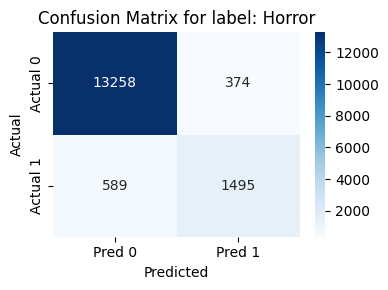

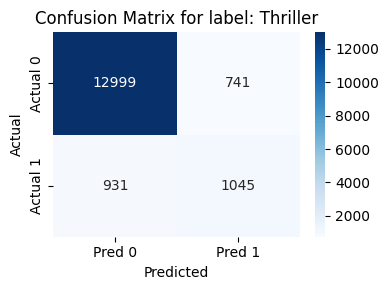

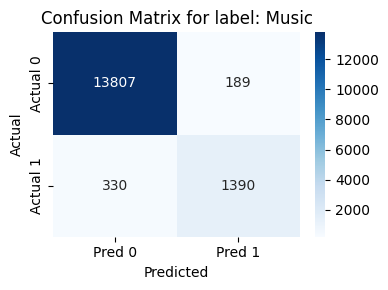

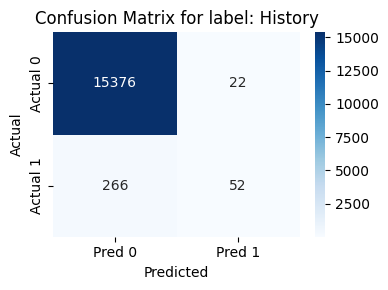

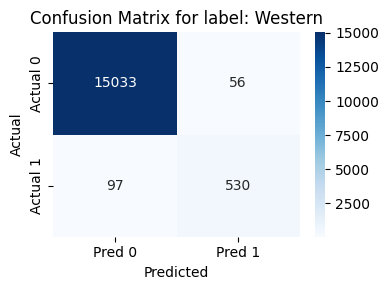

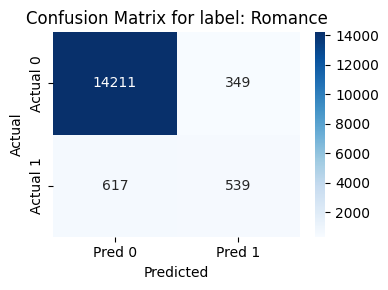

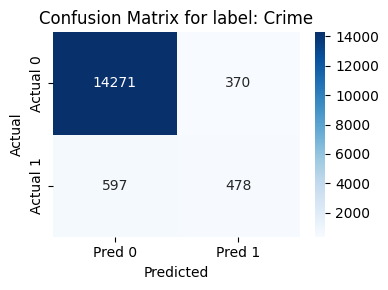

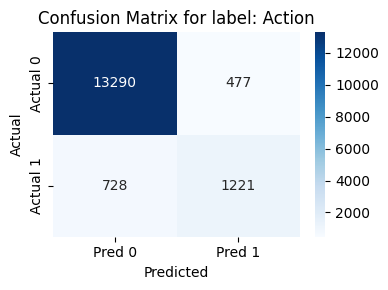

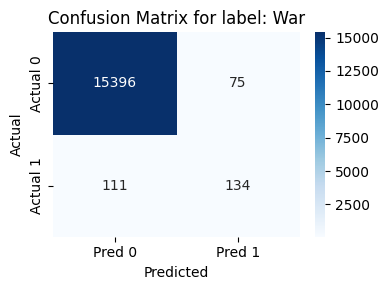

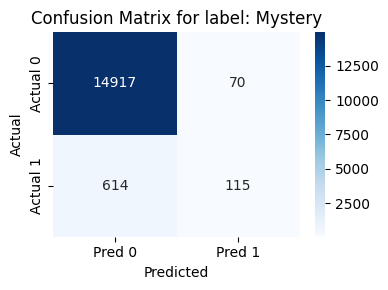

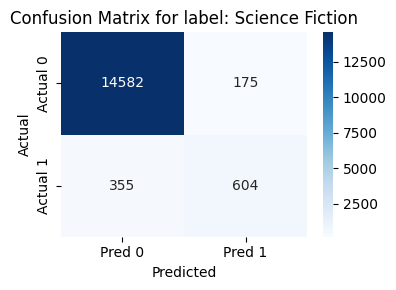

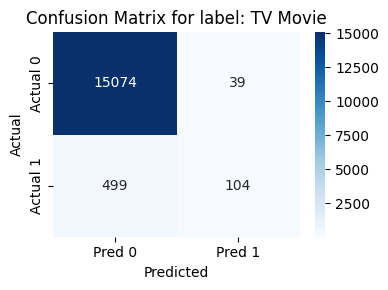

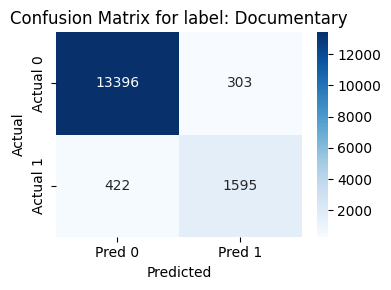

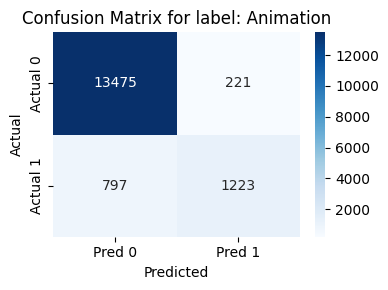

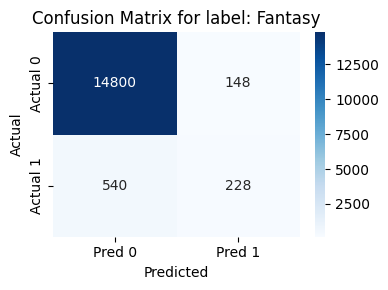

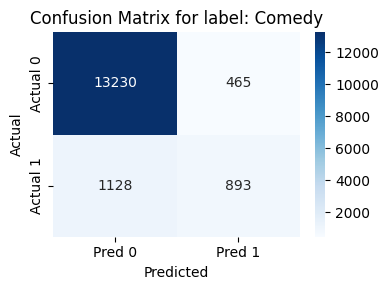

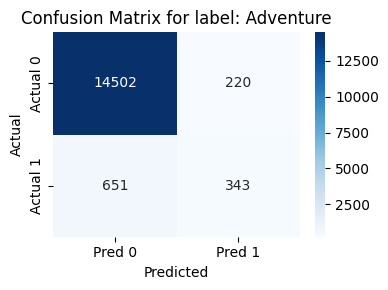

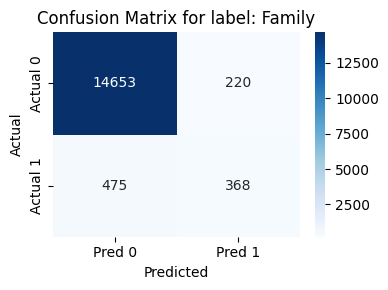

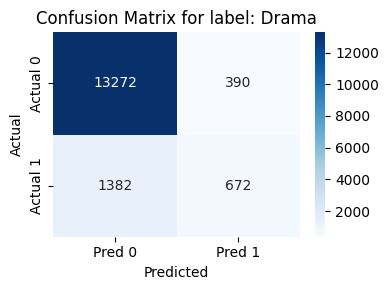

In [41]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import multilabel_confusion_matrix

# y_true: ndarray (num_samples, num_labels)
# y_pred: ndarray (num_samples, num_labels)
# target_list: danh sách tên nhãn tương ứng với cột (length = num_labels)

# Tính confusion matrix cho từng nhãn
mcm = multilabel_confusion_matrix(y_true, y_pred)

# Vẽ heatmap cho từng nhãn
for i, label in enumerate(target_list):
    cm = mcm[i]
    df_cm = pd.DataFrame(cm, index=["Actual 0", "Actual 1"], columns=["Pred 0", "Pred 1"])
    
    plt.figure(figsize=(4, 3))
    sns.heatmap(df_cm, annot=True, fmt="d", cmap="Blues")
    plt.title(f"Confusion Matrix for label: {label}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.show()


<Figure size 1200x1000 with 0 Axes>

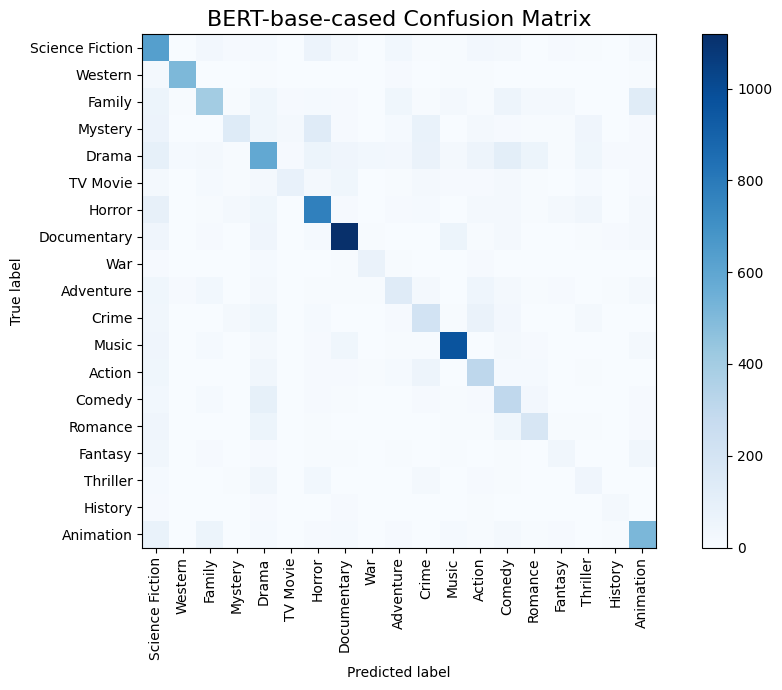

In [104]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Convert one-hot to class labels (CHỈ dùng nếu bạn thực sự đang xử lý multi-class)
y_true = np.argmax(target_values, axis=1)
y_pred = np.argmax(predictions, axis=1)

# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Gán nhãn cho các trục từ target_list
# Lưu ý: cần đảm bảo len(target_list) == số lớp
labels = target_list  # danh sách tên nhãn theo đúng thứ tự chỉ mục

# Create larger figure
plt.figure(figsize=(12, 10))

# Plot the confusion matrix with custom labels
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp_plot = disp.plot(cmap=plt.cm.Blues, xticks_rotation=90)

# Ẩn text bên trong từng ô (nếu muốn đơn giản)
for text in disp_plot.ax_.texts:
    text.set_visible(False)

plt.title("BERT-base-cased Confusion Matrix", fontsize=16)
plt.tight_layout()
plt.show()


## Predicting on raw text

In [121]:
# raw text
raw_text = "A widowed mother's first date in years takes a terrifying turn when she's bombarded with anonymous threatening messages on her phone during their upscale dinner, leaving her questioning if her charming date is behind the harassment."

In [122]:
encoded_text = tokenizer.encode_plus(
    raw_text,
    max_length=MAX_LEN,
    add_special_tokens=True,
    return_token_type_ids=True,
    pad_to_max_length=True,
    return_attention_mask=True,
    return_tensors='pt',
)

In [123]:
input_ids = encoded_text['input_ids'].to(device)
attention_mask = encoded_text['attention_mask'].to(device)
token_type_ids = encoded_text['token_type_ids'].to(device)
output = model(input_ids, attention_mask, token_type_ids)
 # add sigmoid, for the training sigmoid is in BCEWithLogitsLoss
output = torch.sigmoid(output).detach().cpu()
# thresholding at 0.5
output = output.flatten().round().numpy()
output

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0.], dtype=float32)

In [124]:
# Correctly identified the topic of the paper: High energy physics
print(f"Title: {raw_text}")
for idx, p in enumerate(output):
  if p==1:
    print(f"Label: {target_list[idx]}")

Title: A widowed mother's first date in years takes a terrifying turn when she's bombarded with anonymous threatening messages on her phone during their upscale dinner, leaving her questioning if her charming date is behind the harassment.
Label: Thriller
